Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-6-4287924150.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.563900,1.373094,0.483407,0.475493,0.483407,0.467742,0.483407,0.870852,0.773318
2,1.076000,0.874696,0.762667,0.773234,0.762667,0.763074,0.762667,0.940667,0.927656
3,0.783200,0.760724,0.821926,0.833634,0.821926,0.825266,0.821926,0.955481,0.954179
4,0.696700,0.707439,0.849481,0.859603,0.849481,0.851118,0.849481,0.962370,0.968814
5,0.663000,0.699560,0.852444,0.871219,0.852444,0.856306,0.852444,0.963111,0.970925
6,0.626100,0.685292,0.866519,0.873689,0.866519,0.867491,0.866519,0.966630,0.972090
7,0.594700,0.688291,0.866667,0.877494,0.866667,0.868914,0.866667,0.966667,0.970680
8,0.566700,0.690786,0.869926,0.870426,0.869926,0.869361,0.869926,0.967481,0.967636
9,0.537900,0.683927,0.876296,0.876619,0.876296,0.876331,0.876296,0.969074,0.967955
10,0.514900,0.715094,0.869037,0.873166,0.869037,0.868360,0.869037,0.967259,0.963196



✅ Model Performansı:
accuracy: 0.8763
precision: 0.8766
recall: 0.8763
f1: 0.8763
sensitivity: 0.8763
specificity: 0.9691
auc_macro: 0.9680
🕒 Eğitim süresi: 9823.32 sn
🕒 Inference süresi: 103.98 sn


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


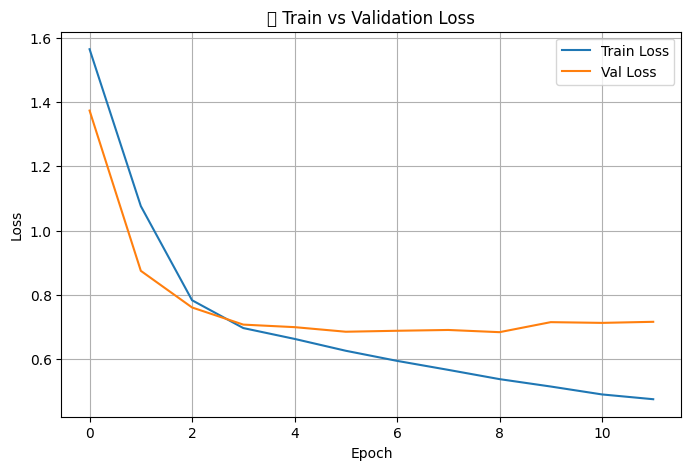

/tmp/ipython-input-6-4287924150.py:163: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


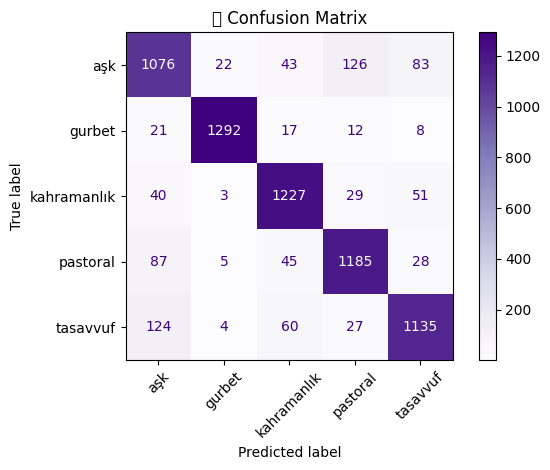

/tmp/ipython-input-6-4287924150.py:185: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


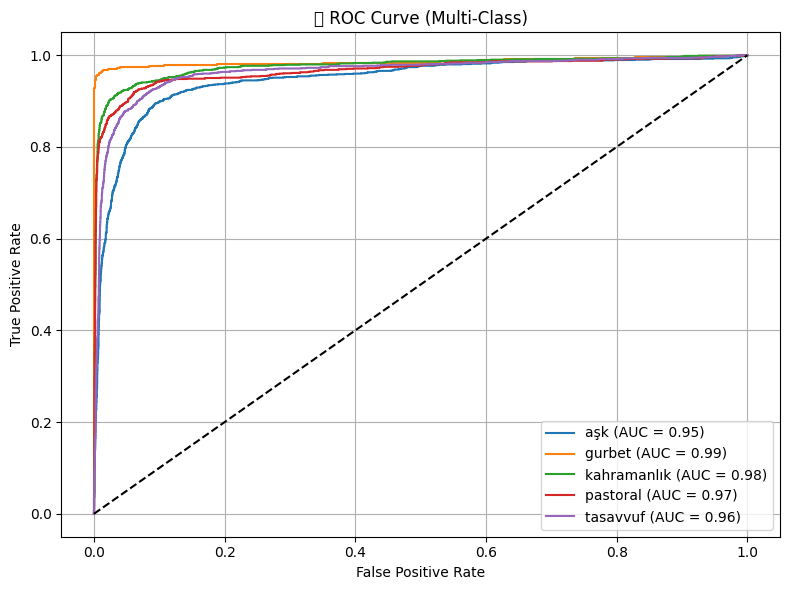

In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kurulum
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding,
                          EarlyStoppingCallback)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}
train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ❗️ DÜZENLENEN KISIM: "text" yerine "islenmis_siir" kullanılmalı
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(etiketler))

# ✅ Değerlendirme fonksiyonu
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i,i]/cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:,i].sum() + cm[i,i]) /
        (cm.sum() - cm[i].sum()) if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/albert_model_best",
    eval_strategy="epoch",                   # her epoch'ta değerlendirme
    save_strategy="epoch",                   # her epoch'ta checkpoint
    learning_rate=1e-5,                      # ⬇️ daha düşük öğrenme oranı
    per_device_train_batch_size=16,          # küçük batch overfitting'i azaltır
    per_device_eval_batch_size=16,
    num_train_epochs=50,                     # 100 fazla, 50 yeterli + early stopping
    weight_decay=0.01,                       # overfitting'e karşı regularization
    warmup_ratio=0.1,                        # ilk adımlarda yavaş öğrenme
    label_smoothing_factor=0.1,              # ezberlemeyi önler
    load_best_model_at_end=True,            # en iyi `eval_loss` olanı geri yükle
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir='./logs',
    logging_strategy="epoch",
    seed=42                                  # tekrar üretilebilirlik
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim ve zaman
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Epoch vs Loss grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Kurulumlar
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          AutoConfig, TrainingArguments, Trainer, DataCollatorWithPadding,
                          EarlyStoppingCallback)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"
with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}
train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ Tokenization
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model + Config (dropout eklendi)
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(etiketler),
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# ✅ Değerlendirme fonksiyonu
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i,i]/cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:,i].sum() + cm[i,i]) /
        (cm.sum() - cm[i].sum()) if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/albert_model_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=100,
    weight_decay=0.01,
    warmup_ratio=0.1,
    label_smoothing_factor=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,
    seed=42,
    report_to=[]
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Tahmin ve değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Epoch vs Loss grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-3101974513.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.633300,1.657665,0.202815,0.145043,0.202815,0.092962,0.202815,0.800704,0.502930
2,1.629600,1.620558,0.194519,0.192439,0.194519,0.120248,0.194519,0.798630,0.525330
3,1.611200,1.600926,0.213481,0.253840,0.213481,0.192969,0.213481,0.803370,0.566492
4,1.563800,1.632065,0.263111,0.315320,0.263111,0.173696,0.263111,0.815778,0.649615


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.633400,1.567631,0.274370,0.202688,0.274370,0.205844,0.274370,0.818593,0.623995
2,1.457800,1.086437,0.621630,0.638165,0.621630,0.621073,0.621630,0.905407,0.860318
3,0.914100,0.799319,0.761185,0.762589,0.761185,0.759851,0.761185,0.940296,0.930462
4,0.742700,0.722813,0.791407,0.790296,0.791407,0.788413,0.791407,0.947852,0.948161
5,0.662000,0.728326,0.811852,0.818757,0.811852,0.812656,0.811852,0.952963,0.951056
6,0.613100,0.601677,0.843852,0.847716,0.843852,0.844630,0.843852,0.960963,0.967771
7,0.566600,0.591220,0.856444,0.858818,0.856444,0.856252,0.856444,0.964111,0.967876
8,0.543400,0.626118,0.841333,0.849028,0.841333,0.838076,0.841333,0.960333,0.970115
9,0.527800,0.546984,0.869926,0.871134,0.869926,0.868558,0.869926,0.967481,0.974541
10,0.511700,0.597146,0.858667,0.862508,0.858667,0.858657,0.858667,0.964667,0.968196



✅ Model Performansı:
accuracy: 0.8699
precision: 0.8711
recall: 0.8699
f1: 0.8686
sensitivity: 0.8699
specificity: 0.9675
auc_macro: 0.9745
🕒 Eğitim süresi: 3832.93 sn
🕒 Inference süresi: 43.70 sn


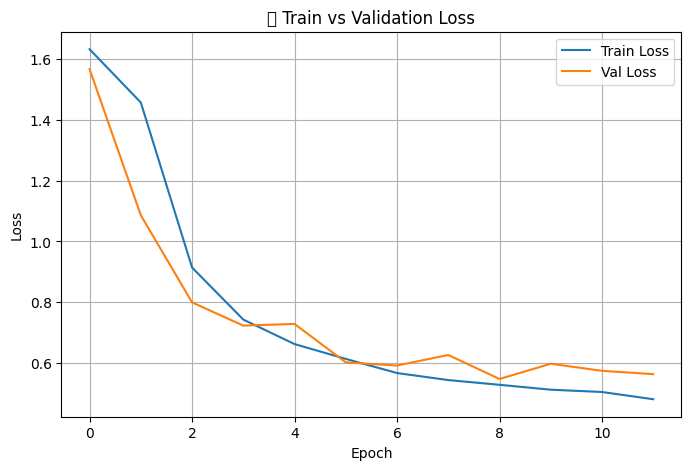

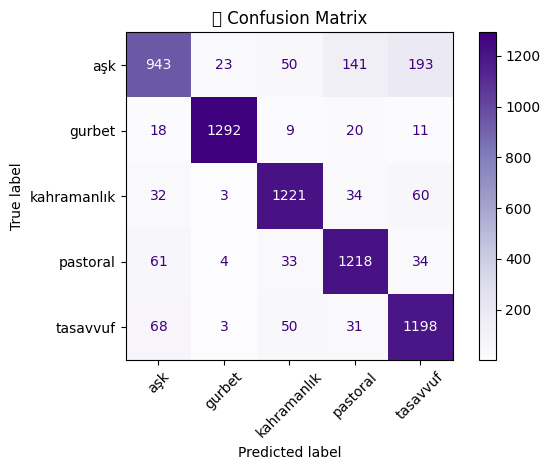

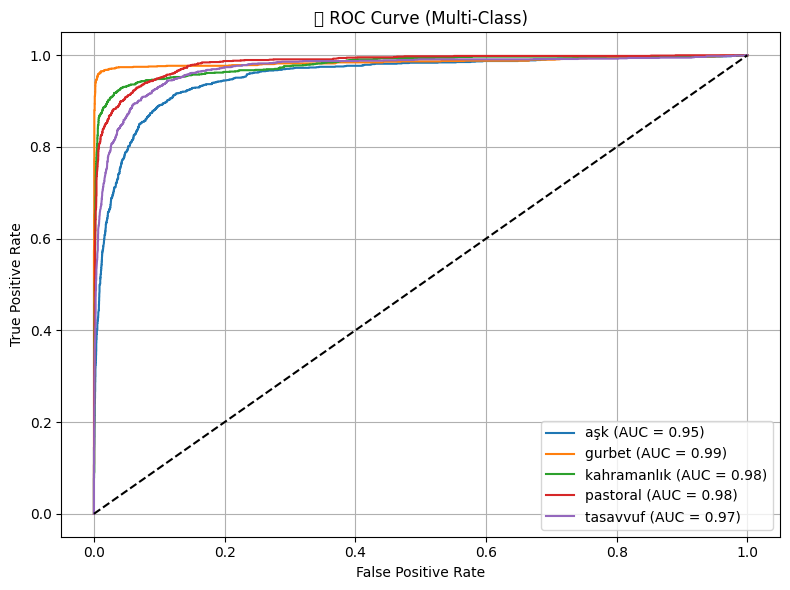

In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Gerekli Kurulumlar (ilk kez yapıyorsan aktif et)
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoConfig, TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}

train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model + Dropout ayarı
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(etiketler),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# ✅ Değerlendirme metrikleri
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i, i] / cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:, i].sum() + cm[i, i]) /
        (cm.sum() - cm[i].sum()) if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/albert_model_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,                    # 🔥 Dengeli öğrenme oranı
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=100,
    weight_decay=0.01,
    warmup_ratio=0.1,
    label_smoothing_factor=0.05,          # 🎯 Sadece biraz yumuşatma
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    report_to=[]
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Tahmin ve değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Kayıp Grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Gerekli Kurulumlar (ilk kez yapıyorsan aktif et)
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoConfig, TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}

train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model + Dropout ayarı
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(etiketler),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# ✅ Değerlendirme metrikleri
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i, i] / cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:, i].sum() + cm[i, i]) /
        (cm.sum() - cm[i].sum()) if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/albert_model_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=3e-16,                    # 🔥 Dengeli öğrenme oranı
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    warmup_ratio=0.1,
    label_smoothing_factor=0.05,          # 🎯 Sadece biraz yumuşatma
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    report_to=[]
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Tahmin ve değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Kayıp Grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4-3585955917.py:120: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.663400,1.653677,0.199852,0.101479,0.199852,0.067717,0.199852,0.799963,0.526062
2,1.665000,1.653677,0.199852,0.101479,0.199852,0.067717,0.199852,0.799963,0.526062
3,1.660800,1.653677,0.199852,0.101479,0.199852,0.067717,0.199852,0.799963,0.526062


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-5-1544384279.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.614400,1.595052,0.269185,0.362103,0.269185,0.201625,0.269185,0.817296,0.615670
2,1.172000,0.965365,0.686667,0.681646,0.686667,0.679828,0.686667,0.921667,0.894659
3,0.802900,0.718022,0.806370,0.808744,0.806370,0.807217,0.806370,0.951593,0.944372
4,0.667700,0.684093,0.819852,0.817930,0.819852,0.816534,0.819852,0.954963,0.954947
5,0.605100,0.633686,0.847407,0.857220,0.847407,0.850089,0.847407,0.961852,0.965107


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.614400,1.595052,0.269185,0.362103,0.269185,0.201625,0.269185,0.817296,0.615670
2,1.172000,0.965365,0.686667,0.681646,0.686667,0.679828,0.686667,0.921667,0.894659
3,0.802900,0.718022,0.806370,0.808744,0.806370,0.807217,0.806370,0.951593,0.944372
4,0.667700,0.684093,0.819852,0.817930,0.819852,0.816534,0.819852,0.954963,0.954947
5,0.605100,0.633686,0.847407,0.857220,0.847407,0.850089,0.847407,0.961852,0.965107
6,0.572400,0.579902,0.860000,0.866397,0.860000,0.861622,0.860000,0.965000,0.971387
7,0.535700,0.567997,0.867852,0.873221,0.867852,0.869083,0.867852,0.966963,0.972142
8,0.509700,0.561844,0.871259,0.873163,0.871259,0.871418,0.871259,0.967815,0.972624
9,0.486800,0.569120,0.867407,0.868458,0.867407,0.866635,0.867407,0.966852,0.973589
10,0.464900,0.598924,0.869037,0.872221,0.869037,0.868663,0.869037,0.967259,0.971928



✅ Model Performansı:
accuracy: 0.8874
precision: 0.8899
recall: 0.8874
f1: 0.8883
sensitivity: 0.8874
specificity: 0.9719
auc_macro: 0.9742
🕒 Eğitim süresi: 5954.74 sn
🕒 Inference süresi: 57.71 sn


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


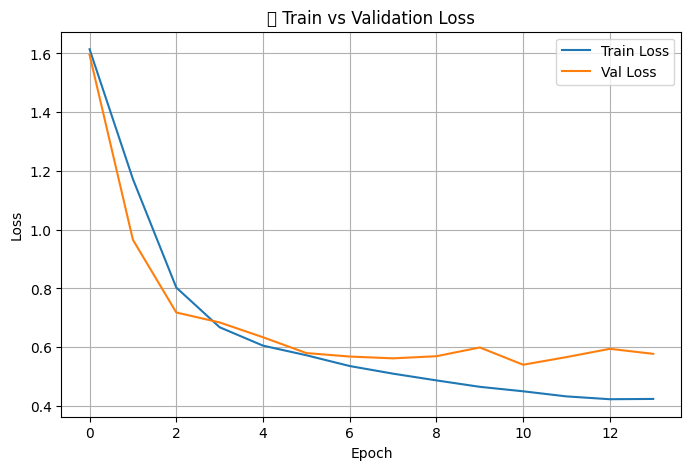

/tmp/ipython-input-5-1544384279.py:176: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


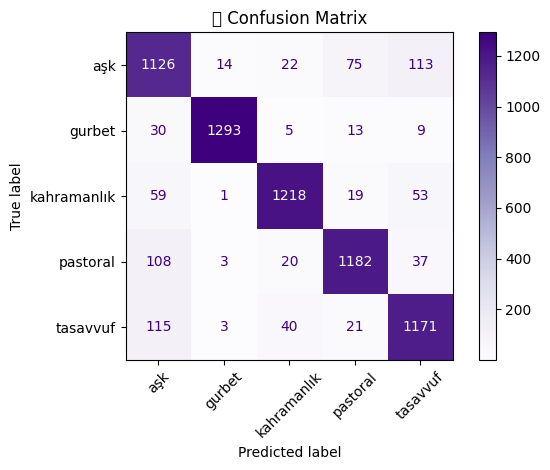

/tmp/ipython-input-5-1544384279.py:198: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


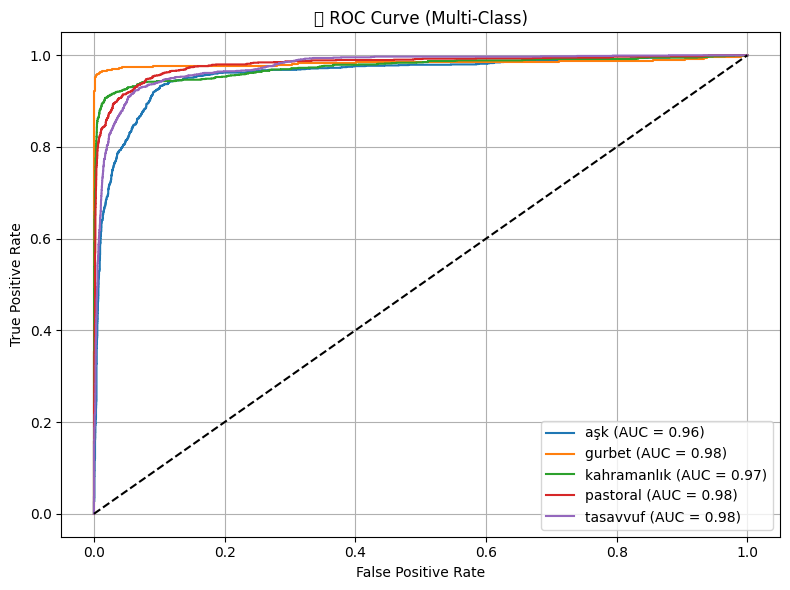

In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Gerekli Kurulumlar (ilk kez yapıyorsan aktif et)
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoConfig, TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}

train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model + Dropout ayarı
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(etiketler),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# ✅ Değerlendirme metrikleri
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i, i] / cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:, i].sum() + cm[i, i]) /
        (cm.sum() - cm[i].sum()) if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

# ✅ Eğitim ayarları
# ✅ Eğitim ayarları (DÜZENLENMİŞ)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/albert_model_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,                      # ✅ makul bir değer
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,                     # ✅ makul, erken durdurma var zaten
    weight_decay=0.01,
    warmup_ratio=0.1,
    label_smoothing_factor=0.05,             # bırakılabilir
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    report_to=[]
)

# ✅ Trainer (değişiklik yok)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


# ✅ Eğitim başlat
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Tahmin ve değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Kayıp Grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-2566556733.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.634100,1.597692,0.222222,0.226326,0.222222,0.157914,0.222222,0.805556,0.592838
2,1.514900,1.477024,0.434370,0.496068,0.434370,0.362520,0.434370,0.858593,0.797443
3,0.993500,1.000611,0.694222,0.710649,0.694222,0.682525,0.694222,0.923556,0.901147
4,0.767500,0.794147,0.777037,0.777377,0.777037,0.772915,0.777037,0.944259,0.940987
5,0.665400,0.674482,0.823407,0.829722,0.823407,0.825556,0.823407,0.955852,0.954754
6,0.611900,0.613065,0.850074,0.854250,0.850074,0.851108,0.850074,0.962519,0.967474
7,0.560600,0.558817,0.867111,0.872269,0.867111,0.868559,0.867111,0.966778,0.972331


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.634100,1.597692,0.222222,0.226326,0.222222,0.157914,0.222222,0.805556,0.592838
2,1.514900,1.477024,0.434370,0.496068,0.434370,0.362520,0.434370,0.858593,0.797443
3,0.993500,1.000611,0.694222,0.710649,0.694222,0.682525,0.694222,0.923556,0.901147
4,0.767500,0.794147,0.777037,0.777377,0.777037,0.772915,0.777037,0.944259,0.940987
5,0.665400,0.674482,0.823407,0.829722,0.823407,0.825556,0.823407,0.955852,0.954754
6,0.611900,0.613065,0.850074,0.854250,0.850074,0.851108,0.850074,0.962519,0.967474
7,0.560600,0.558817,0.867111,0.872269,0.867111,0.868559,0.867111,0.966778,0.972331
8,0.529600,0.635680,0.847704,0.852441,0.847704,0.845897,0.847704,0.961926,0.968841
9,0.509300,0.573329,0.863852,0.867093,0.863852,0.862384,0.863852,0.965963,0.972460



✅ Model Performansı:
accuracy: 0.8671
precision: 0.8723
recall: 0.8671
f1: 0.8686
sensitivity: 0.8671
specificity: 0.9668
auc_macro: 0.9723
🕒 Eğitim süresi: 3749.68 sn
🕒 Inference süresi: 57.96 sn


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


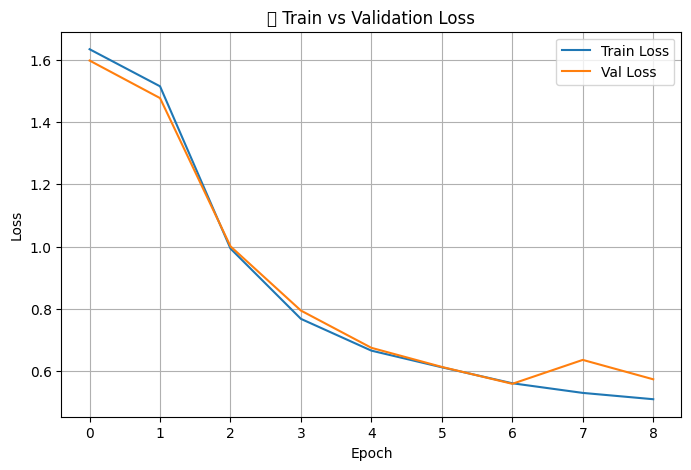

/tmp/ipython-input-6-2566556733.py:176: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


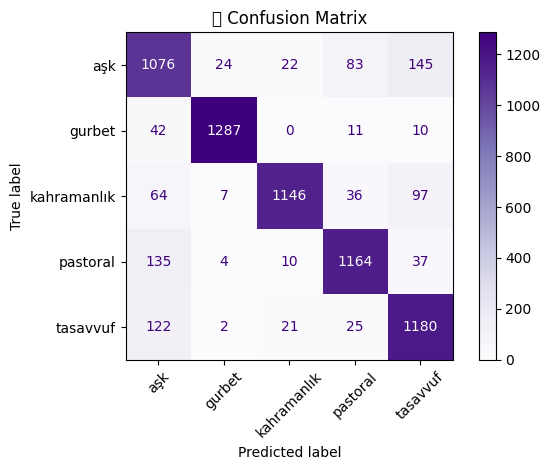

/tmp/ipython-input-6-2566556733.py:198: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


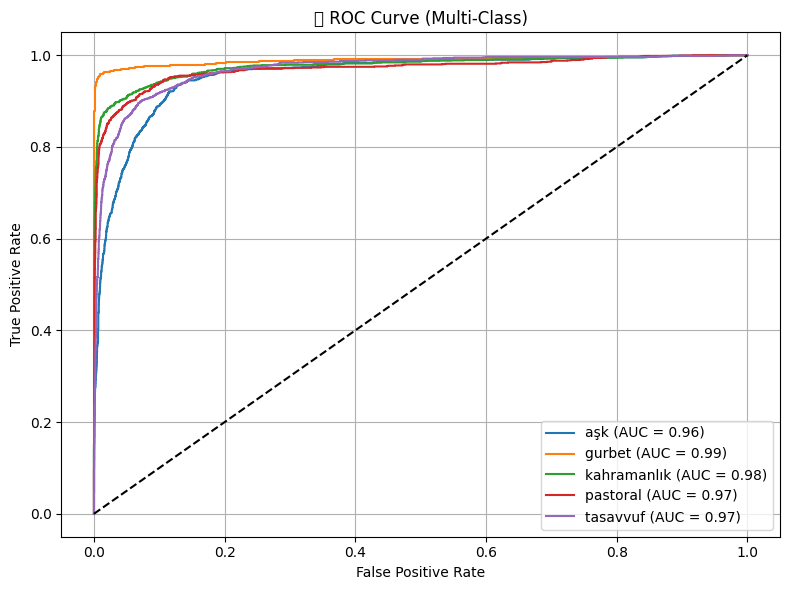

In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Gerekli Kurulumlar (ilk kez yapıyorsan aktif et)
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoConfig, TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}

train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model + Dropout ayarı
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(etiketler),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# ✅ Değerlendirme metrikleri
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i, i] / cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:, i].sum() + cm[i, i]) /
        (cm.sum() - cm[i].sum()) if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

# ✅ Eğitim ayarları
# ✅ Eğitim ayarları (DÜZENLENMİŞ)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/albert_model_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=1e-5,                      # ✅ makul bir değer
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,                     # ✅ makul, erken durdurma var zaten
    weight_decay=0.03,
    warmup_ratio=0.1,
    label_smoothing_factor=0.05,             # bırakılabilir
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    report_to=[]
)

# ✅ Trainer (değişiklik yok)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# ✅ Eğitim başlat
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Tahmin ve değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Kayıp Grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Map:   0%|          | 0/15744 [00:00<?, ? examples/s]

Map:   0%|          | 0/6750 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-8-400621288.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.407800,0.984621,0.606963,0.635901,0.606963,0.595341,0.606963,0.901741,0.859091
2,0.855100,0.749487,0.753778,0.767214,0.753778,0.748414,0.753778,0.938444,0.925275
3,0.632100,0.583381,0.799704,0.807673,0.799704,0.801268,0.799704,0.949926,0.951197
4,0.524300,0.556997,0.818222,0.822627,0.818222,0.816712,0.818222,0.954556,0.960618
5,0.470100,0.508009,0.843704,0.846877,0.843704,0.844492,0.843704,0.960926,0.966334
6,0.419600,0.427741,0.860296,0.859829,0.860296,0.859929,0.860296,0.965074,0.973276


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.407800,0.984621,0.606963,0.635901,0.606963,0.595341,0.606963,0.901741,0.859091
2,0.855100,0.749487,0.753778,0.767214,0.753778,0.748414,0.753778,0.938444,0.925275
3,0.632100,0.583381,0.799704,0.807673,0.799704,0.801268,0.799704,0.949926,0.951197
4,0.524300,0.556997,0.818222,0.822627,0.818222,0.816712,0.818222,0.954556,0.960618
5,0.470100,0.508009,0.843704,0.846877,0.843704,0.844492,0.843704,0.960926,0.966334
6,0.419600,0.427741,0.860296,0.859829,0.860296,0.859929,0.860296,0.965074,0.973276
7,0.392400,0.437165,0.861481,0.862089,0.861481,0.860818,0.861481,0.965370,0.973457
8,0.365200,0.503385,0.852148,0.853899,0.852148,0.849478,0.852148,0.963037,0.971838



✅ Model Performansı:
accuracy: 0.8603
precision: 0.8598
recall: 0.8603
f1: 0.8599
sensitivity: 0.8603
specificity: 0.9651
auc_macro: 0.9733
🕒 Eğitim süresi: 3330.77 sn
🕒 Inference süresi: 57.45 sn


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


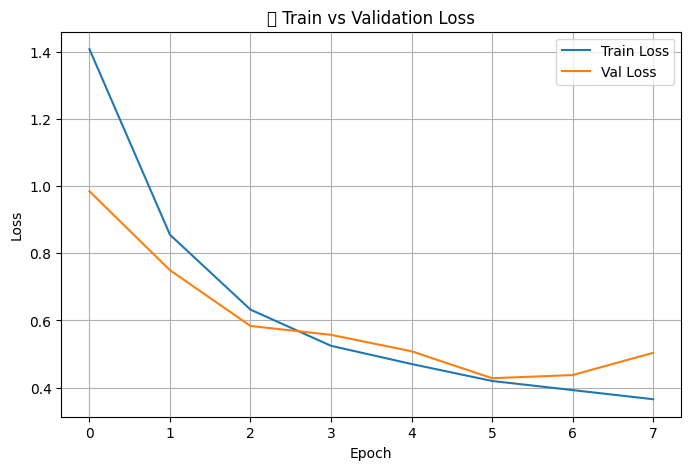

/tmp/ipython-input-8-400621288.py:173: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


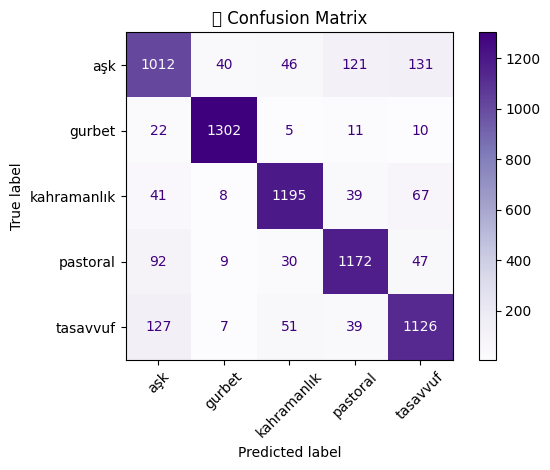

/tmp/ipython-input-8-400621288.py:195: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


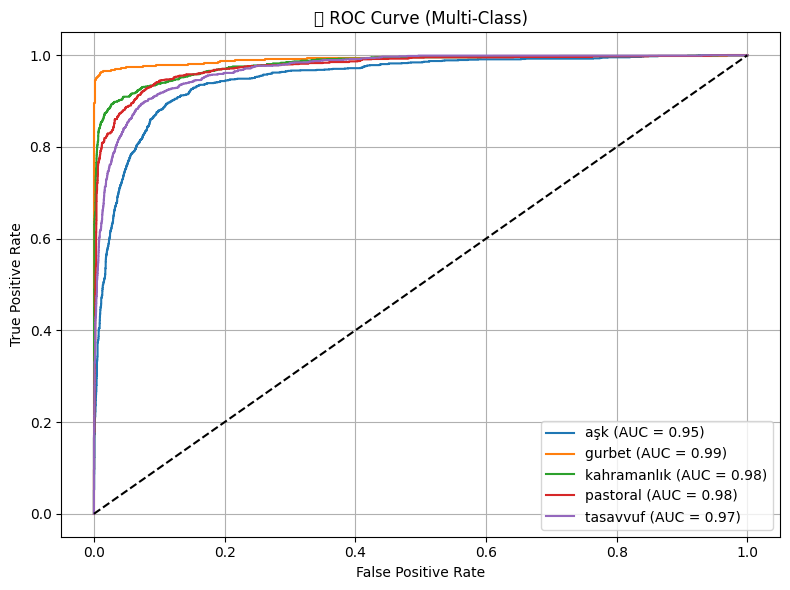

In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Gerekli Kurulumlar (ilk kez yapıyorsan aktif et)
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoConfig, TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path   = "/content/drive/MyDrive/val_sonkelime_temiz.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}

train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model + Dropout ayarı
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(etiketler),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# ✅ Değerlendirme metrikleri
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i, i] / cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:, i].sum() + cm[i, i]) /
        (cm.sum() - cm[i].sum()) if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

# ✅ Eğitim ayarları
# ✅ Eğitim ayarları (DÜZENLENMİŞ)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/albert_model_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=7e-6,                      # ✅ makul bir değer
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=100,                     # ✅ makul, erken durdurma var zaten
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    report_to=[]
)

# ✅ Trainer (değişiklik yok)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# ✅ Eğitim başlat
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Tahmin ve değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Kayıp Grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-2874999439.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.526200,0.945307,0.689042,0.687794,0.689023,0.685602,0.689023,0.922260,0.888729
2,0.813600,0.655280,0.828629,0.833047,0.828627,0.830227,0.828627,0.957157,0.956747
3,0.640800,0.571996,0.856857,0.858118,0.856850,0.856965,0.856850,0.964214,0.970073
4,0.566400,0.546562,0.873861,0.881872,0.873853,0.875607,0.873853,0.968465,0.972194
5,0.526800,0.523111,0.884308,0.885265,0.884308,0.884285,0.884308,0.971078,0.975349
6,0.493900,0.498237,0.898866,0.902310,0.898860,0.899623,0.898860,0.974717,0.979052
7,0.462400,0.485983,0.909535,0.913331,0.909534,0.910650,0.909534,0.977384,0.978232
8,0.439500,0.483508,0.912203,0.917422,0.912204,0.913410,0.912204,0.978051,0.983467
9,0.418900,0.475021,0.922649,0.922384,0.922645,0.922317,0.922645,0.980663,0.982816
10,0.396800,0.448158,0.928317,0.929546,0.928314,0.928656,0.928314,0.982080,0.986223


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.526200,0.945307,0.689042,0.687794,0.689023,0.685602,0.689023,0.922260,0.888729
2,0.813600,0.655280,0.828629,0.833047,0.828627,0.830227,0.828627,0.957157,0.956747
3,0.640800,0.571996,0.856857,0.858118,0.856850,0.856965,0.856850,0.964214,0.970073
4,0.566400,0.546562,0.873861,0.881872,0.873853,0.875607,0.873853,0.968465,0.972194
5,0.526800,0.523111,0.884308,0.885265,0.884308,0.884285,0.884308,0.971078,0.975349
6,0.493900,0.498237,0.898866,0.902310,0.898860,0.899623,0.898860,0.974717,0.979052
7,0.462400,0.485983,0.909535,0.913331,0.909534,0.910650,0.909534,0.977384,0.978232
8,0.439500,0.483508,0.912203,0.917422,0.912204,0.913410,0.912204,0.978051,0.983467
9,0.418900,0.475021,0.922649,0.922384,0.922645,0.922317,0.922645,0.980663,0.982816
10,0.396800,0.448158,0.928317,0.929546,0.928314,0.928656,0.928314,0.982080,0.986223



✅ Model Performansı:
accuracy: 0.9641
precision: 0.9641
recall: 0.9641
f1: 0.9641
sensitivity: 0.9641
specificity: 0.9910
auc_macro: 0.9909
🕒 Eğitim süresi: 10918.25 sn
🕒 Inference süresi: 36.18 sn


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


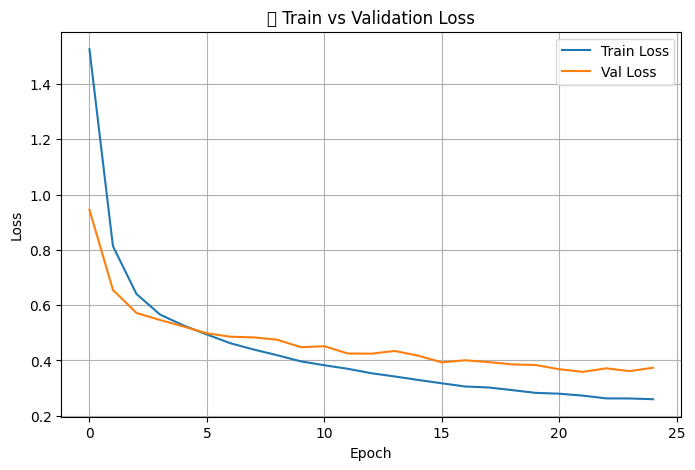

/tmp/ipython-input-1-2874999439.py:176: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


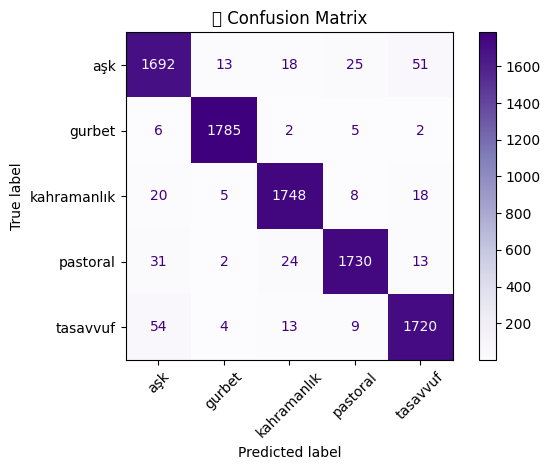

/tmp/ipython-input-1-2874999439.py:198: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


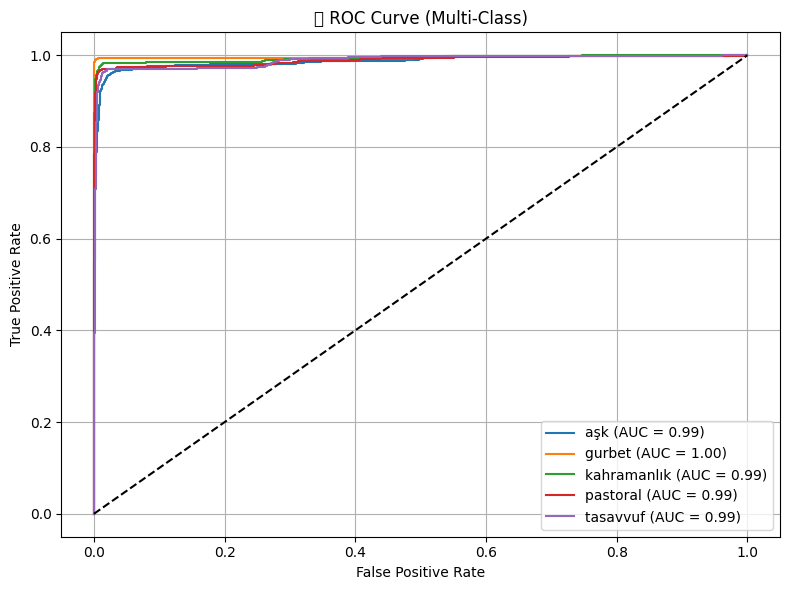

In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Gerekli Kurulumlar (ilk kez yapıyorsan aktif et)
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoConfig, TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}

train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model + Dropout ayarı
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(etiketler),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# ✅ Değerlendirme metrikleri
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i, i] / cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:, i].sum() + cm[i, i]) /
        (cm.sum() - cm[i].sum()) if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

# ✅ Eğitim ayarları
# ✅ Eğitim ayarları (DÜZENLENMİŞ)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/albert_model_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,                      # ✅ makul bir değer
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,                     # ✅ makul, erken durdurma var zaten
    weight_decay=0.01,
    warmup_ratio=0.1,
    label_smoothing_factor=0.05,             # bırakılabilir
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    report_to=[]
)

# ✅ Trainer (değişiklik yok)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


# ✅ Eğitim başlat
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Tahmin ve değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Kayıp Grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import json
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Veri yolları
train_path = "/content/drive/MyDrive/train_sonkelime_temiz.json"
val_path = "/content/drive/MyDrive/val_sonkelime_temiz.json"

# --- 1. Türkçe Eşanlamlılar Sözlüğü ---
# Bu sözlüğü ihtiyaçlarınıza göre genişletebilirsiniz.
synonym_dict = defaultdict(list)
synonym_dict.update({
    "aşk": ["sevgi", "sevda", "tutku", "aşık", "muhabbet"],
    "yürek": ["kalp", "gönül", "yürek"],
    "gurbet": ["hasret", "özlem", "uzak", "sıla", "dışarısı"],
    "vatan": ["yurt", "memleket", "toprak"],
    "kahraman": ["yiğit", "alp", "cesur", "kahramanlık"],
    "ömür": ["yaşam", "hayat", "ömür"],
    "çile": ["eziyet", "acı", "ızdırap", "dert"],
    "göz": ["nazar", "bakar", "gözler"],
    "yolcu": ["yolcu", "gezgin", "seyyah"],
    "tümsek": ["tepe", "yükseklik"],
    "zulüm": ["acımasızlık", "işkence"],
    "hasret": ["özlem", "gurbet"],
    "dağ": ["cebel", "sıradağ"],
    "acı": ["ızdırap", "çile"],
    "dünya": ["alem", "cihan", "evren"],
    "insan": ["kişi", "birey", "beşer"],
    "dost": ["arkadaş", "yoldaş", "ahbap"],
    "kader": ["yazgı", "talih"],
    "sessiz": ["sakin", "dingin", "suspus"],
    "ırmak": ["nehir", "akarsu"],
    "deniz": ["derya", "umman"],
    "gül": ["çiçek", "gonca"],
    "bülbül": ["şakrak", "kanarya"],
    "hürriyet": ["özgürlük", "bağımsızlık"],
    "savaş": ["harp", "muharebe", "çatışma"],
    "zafer": ["galibiyet", "yenme"],
    "şair": ["ozan", "dizeler", "şiirci"],
    "şiir": ["koşuk", "manzume"],
    "mübarek": ["kutlu", "uğurlu"],
    "toprak": ["arazi", "yer"],
    "kan": ["dem", "doku"],
    "can": ["ruh", "hayat"],
    "yıl": ["sene"],
    "gün": ["gündüz"],
    "gece": ["leyl"],
    "ışık": ["nur", "aydınlık"],
    "zaman": ["vakit", "çağ", "devir"],
    "kalp": ["yürek", "gönül", "çehre"],
    "umut": ["beklenti", "hayal"],
    "düşman": ["hasım", "rakip"],
    "cennet": ["uçmak", "adan"],
    "cehennem": ["tamuy"],
    "su": ["ab"],
    "ateş": ["od", "nar"],
    "güneş": ["gün", "hürşit"],
    "ay": ["kamer"],
    "yıldız": ["ahter"],
    "rüzgar": ["yel", "bad"],
    "ağaç": ["dar", "nebat"],
    "yaprak": ["varak"],
    "neşe": ["sevinç", "coşku"],
    "keder": ["üzüntü", "gam"],
    "hayal": ["düş", "hülya"],
    "bilgi": ["ilim", "malumat"],
    "okul": ["mektep"],
    "öğretmen": ["hoca", "muallim"],
    "öğrenci": ["talebe", "şakirt"],
    "ders": ["konu", "etüt"],
    "kitap": ["eser", "yazma"],
    "yazmak": ["kaleme almak", "tashih etmek"],
    "okumak": ["mütalaa etmek"],
    "konuşmak": ["söylemek", "demek"],
    "dinlemek": ["kulak vermek"],
    "görmek": ["bakmak", "seyretmek"],
    "duymak": ["işitmek"],
    "yemek": ["aş", "gıda"],
    "içmek": ["nûş etmek"],
    "uyumak": ["horlamak", "uykuya dalmak"],
    "uyanmak": ["gözünü açmak"],
    "gitmek": ["varmak", "seyahat etmek"],
    "gelmek": ["ulaşmak", "teşrif etmek"],
    "koşmak": ["sprint atmak", "hızla gitmek"],
    "yürümek": ["adımlamak", "gezmek"],
    "oturmak": ["ikamet etmek", "çökmek"],
    "kalkmak": ["ayağa kalkmak"],
    "sevmek": ["aşık olmak", "beğenmek"],
    "nefret": ["kin", "düşmanlık"],
    "mutlu": ["mesut", "şen"],
    "üzgün": ["kederli", "mahzun"],
    "büyük": ["iri", "ulu"],
    "küçük": ["ufak", "minik"],
    "iyi": ["güzel", "hoş"],
    "kötü": ["fena", "çirkin"],
    "doğru": ["hakikat", "gerçek"],
    "yanlış": ["hatalı", "eksik"],
    "sıcak": ["hararetli"],
    "soğuk": ["buz gibi", "serin"],
    "hızlı": ["çabuk", "süratli"],
    "yavaş": ["ağır", "sürüncemeli"],
    "açık": ["vazıh", "aydınlık"],
    "kapalı": ["örtülü", "mahcup"],
    "yeni": ["cedit", "taze"],
    "eski": ["köhne", "antik"],
    "bol": ["çok", "fazla"],
    "az": ["kıt", "eksik"],
    "temiz": ["pak", "saf"],
    "kirli": ["pis", "pasaklı"],
    "zor": ["güç", "çetin"],
    "kolay": ["basit", "rahat"],
    "yüksek": ["ali", "yüce"],
    "alçak": ["pes", "bayağı"],
    "güzel": ["cemil", "hüsnü"],
    "çirkin": ["nahoş", "mekruh"],
    "sessiz": ["sakin", "dingin"],
    "gürültülü": ["patırtılı", "cızırtılı"],
    "aydınlık": ["ışıklı", "parlak"],
    "karanlık": ["zulmetli", "siyah"]
})


# --- 2. Veri Artırma Fonksiyonları (EDA) ---

def get_synonyms(word, synonym_dict):
    """Bir kelimenin eşanlamlılarını döndürür."""
    return synonym_dict.get(word, [word])

def synonym_replacement(words, n):
    """
    Kelimelerin n kadarını eşanlamlılarıyla değiştirir.
    words: Liste halinde kelimeler.
    n: Kaç kelimenin değiştirileceği.
    """
    new_words = list(words)
    random_word_list = list(set([word for word in words if get_synonyms(word, synonym_dict)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word, synonym_dict)
        if len(synonyms) > 1:
            synonym = random.choice(list(set(synonyms) - set([random_word])))
            # Kelimenin birden fazla geçtiği durumlarda tüm örneklerini değiştirmek yerine ilkini değiştiririz.
            # Daha sofistike bir yaklaşım için tüm geçişleri bulup değiştirmek gerekebilir.
            if random_word in new_words:
                idx = new_words.index(random_word)
                new_words[idx] = synonym
                num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def random_insertion(words, n):
    """
    Rastgele seçilen n tane kelimenin eşanlamlılarını rastgele yerlere ekler.
    """
    new_words = list(words)
    for _ in range(n):
        word_to_insert = random.choice(words)
        synonyms = get_synonyms(word_to_insert, synonym_dict)
        if synonyms: # Eşanlamlı varsa
            new_word = random.choice(synonyms)
            new_words.insert(random.randint(0, len(new_words)), new_word)
    return ' '.join(new_words)

def random_swap(words, n):
    """
    n kez rastgele iki kelimenin yerini değiştirir.
    """
    new_words = list(words)
    if len(new_words) < 2: # Takas için en az 2 kelime olmalı
        return ' '.join(words)
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return ' '.join(new_words)

def random_deletion(words, p):
    """
    Kelimelerin p olasılıkla silinmesini sağlar.
    """
    if len(words) == 1:
        return ' '.join(words)
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        return random.choice(words) # Tüm kelimeler silinirse, orijinalden rastgele birini bırak
    return ' '.join(new_words)

def augment_text(text, num_aug=1):
    """
    Bir metni çeşitli EDA teknikleriyle artırır.
    num_aug: Her orijinal metinden kaç artırılmış örnek oluşturulacağı.
    """
    words = text.split()
    augmented_texts = []
    if not words: # Boş metinler için koruma
        return [""] * num_aug

    for _ in range(num_aug):
        aug_text_list = list(words) # Kopyasını al

        choice = random.randint(0, 3)
        if choice == 0: # Eşanlamlı kelime değiştirme
            aug_text_list = synonym_replacement(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 1: # Rastgele ekleme
            aug_text_list = random_insertion(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 2: # Rastgele takas
            aug_text_list = random_swap(aug_text_list, max(1, int(len(aug_text_list) * 0.1)))
        elif choice == 3: # Rastgele silme
            aug_text_list = random_deletion(aug_text_list, 0.1)

        augmented_texts.append(aug_text_list) # Zaten string olarak döndürüyor

    return augmented_texts


# --- 3. Veri Okuma ve Birleştirme ---

print("Veri setleri okunuyor...")
try:
    with open(train_path, 'r', encoding='utf-8') as f:
        train_data = json.load(f) # Load the entire file as a single JSON object (list of dicts)
    with open(val_path, 'r', encoding='utf-8') as f:
        val_data = json.load(f) # Load the entire file as a single JSON object (list of dicts)
except FileNotFoundError:
    print(f"Hata: Dosya bulunamadı. Lütfen '{train_path}' ve '{val_path}' yollarını kontrol edin.")
    # Colab kullanıyorsanız, drive'ı bağladığınızdan emin olun:
    # from google.colab import drive
    # drive.mount('/content/drive')
    exit()
except json.JSONDecodeError as e:
    print(f"JSON Decode Hatası: {e}")
    print("Lütfen JSON dosyanızın geçerli bir formatta olduğundan emin olun.")
    exit()


df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)

# Toplam veri setini oluşturalım, böylece yeniden bölebiliriz.
# Eğer test setiniz tamamen ayrı ve hiç değişmeyecekse, bu birleştirmeyi yapmayıp sadece train_data'yı artırıp sonra bölmeniz gerekir.
# Ancak genel yaklaşım, train ve val'ı birleştirip artırma yapıp sonra yeniden bölmektir.
df_combined = pd.concat([df_train, df_val], ignore_index=True)
print(f"Toplam orijinal veri boyutu: {len(df_combined)} örnek.")

# --- 4. Veri Artırma Uygulaması ---

print("Eğitim verisi artırılıyor...")
augmented_records = []
# Her orijinal şiir için 1 artırılmış örnek oluşturacağız. (num_aug=1)
# Eğer daha fazla artırma istiyorsanız, num_aug değerini artırabilirsiniz (örn. num_aug=2).
# Bu durumda veri setiniz (orijinal + num_aug * orijinal) boyutunda olur.
# Mevcut haliyle, her şiirden 1 artırılmış kopya oluşturulup orijinalle birleştirilecektir.
for index, row in df_combined.iterrows():
    original_siir = row['islenmis_siir']
    augmented_siirs = augment_text(original_siir, num_aug=1) # Her orijinal için 1 yeni örnek
    for aug_siir in augmented_siirs:
        augmented_records.append({
            "baslik": row["baslik"],
            "siir": row["siir"],
            "konu": row["konu"],
            "islenmis_siir": aug_siir
        })

df_augmented = pd.DataFrame(augmented_records)

# Orijinal veriyi ve artırılmış veriyi birleştir
df_final_augmented = pd.concat([df_combined, df_augmented], ignore_index=True)
print(f"Veri artırma sonrası toplam veri boyutu: {len(df_final_augmented)} örnek.")

# --- 5. Veri Bölme ve Kaydetme ---

output_dir = "/content/drive/MyDrive/"

def save_dataframes_to_jsonl(df_train_part, df_val_part, train_filename, val_filename):
    """DataFrame'leri JSONL formatında kaydeder."""
    train_output_path = f"{output_dir}{train_filename}"
    val_output_path = f"{output_dir}{val_filename}"

    # Save as JSON (list of objects) instead of JSONL (line-delimited JSON)
    with open(train_output_path, 'w', encoding='utf-8') as f:
        json.dump(df_train_part.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

    with open(val_output_path, 'w', encoding='utf-8') as f:
        json.dump(df_val_part.to_dict(orient='records'), f, ensure_ascii=False, indent=4)

    print(f"Dosyalar kaydedildi: {train_output_path} ve {val_output_path}")


# 5.1. %70 Eğitim / %30 Doğrulama Ayrımı
print("\n%70 Eğitim / %30 Doğrulama ayrımı yapılıyor...")
train_70, val_30 = train_test_split(
    df_final_augmented,
    test_size=0.3,
    stratify=df_final_augmented['konu'], # Konu dağılımını koru
    random_state=42
)
print(f"70/30 Eğitim Boyutu: {len(train_70)}, Doğrulama Boyutu: {len(val_30)}")
save_dataframes_to_jsonl(train_70, val_30, "augmented_train_70_30.json", "augmented_val_70_30.json")

# 5.2. %80 Eğitim / %20 Doğrulama Ayrımı
print("\n%80 Eğitim / %20 Doğrulama ayrımı yapılıyor...")
train_80, val_20 = train_test_split(
    df_final_augmented,
    test_size=0.2,
    stratify=df_final_augmented['konu'], # Konu dağılımını koru
    random_state=42
)
print(f"80/20 Eğitim Boyutu: {len(train_80)}, Doğrulama Boyutu: {len(val_20)}")
save_dataframes_to_jsonl(train_80, val_20, "augmented_train_80_20.json", "augmented_val_80_20.json")

print("\nVeri artırma ve bölme işlemleri tamamlandı.")
print("Şimdi bu yeni JSON dosyalarını (örneğin augmented_train_80_20.json) eğitim kodunuzda kullanabilirsiniz.")

Veri setleri okunuyor...
Toplam orijinal veri boyutu: 22494 örnek.
Eğitim verisi artırılıyor...
Veri artırma sonrası toplam veri boyutu: 44988 örnek.

%70 Eğitim / %30 Doğrulama ayrımı yapılıyor...
70/30 Eğitim Boyutu: 31491, Doğrulama Boyutu: 13497
Dosyalar kaydedildi: /content/drive/MyDrive/augmented_train_70_30.json ve /content/drive/MyDrive/augmented_val_70_30.json

%80 Eğitim / %20 Doğrulama ayrımı yapılıyor...
80/20 Eğitim Boyutu: 35990, Doğrulama Boyutu: 8998
Dosyalar kaydedildi: /content/drive/MyDrive/augmented_train_80_20.json ve /content/drive/MyDrive/augmented_val_80_20.json

Veri artırma ve bölme işlemleri tamamlandı.
Şimdi bu yeni JSON dosyalarını (örneğin augmented_train_80_20.json) eğitim kodunuzda kullanabilirsiniz.
